#### In this notebook we will attempt to build a model to identify the probability of a customer churning from a bank. 
#### Customer churn is usually a 'detection' type of problem. This means that there can be severe class imbalance. We will confirm it when we do the exploratory data analysis.
#### Whenever there is such a class imbalance we need to take special care to solve it as a naive 'positive only' classifier can give very good results which won't be very helpful

#### Approach
1. Import the data
2. Perform exploratory analysis\
    2.1. Check for null values - Take approriate steps to address the issue\
    2.2. Check for outliers - Take appropriate steps to address the issue\
    2.3. Explore the distribution of features and target variable (suspected to be imbalanced)
3. Feature Engineering
4. Shortlist the models to be used for the use case
5. Standardize the features if required by certain models
6. Split the data under train.csv in training and validation sets
7. Train the models
8. Select the final model
9 Create a pipeline for the model to predict on the test set and generate the output in the desired format


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt # from data visualization
import seaborn as sns # for data visualization

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


### Step 1: Import the data

In [2]:
# Storing the training and test data filepath in a variable for easy access
train_data_filepath='''/kaggle/input/playground-series-s4e1/train.csv'''
test_data_filepath='''/kaggle/input/playground-series-s4e1/test.csv'''

In [3]:
# import the data into pandas dataframe
df_train=pd.read_csv(train_data_filepath, index_col="id")
df_test=pd.read_csv(test_data_filepath)

In [4]:
# let's check the first few rows of the train data
# this will tell us whether the import went through fine and how do the columns look like
df_train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


### Step 2: Exploratory Data Analysis

In [6]:
# checking the size
df_train.shape

(165034, 13)

In [7]:
# checking the different column names
df_train.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

### Checking null-values

In [8]:
# getting the information about the columns
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


#### There are a total of 165,034 rows and each of the attribute has the same number of non-null values. Hence, we don't have a problem of null values here

In [9]:
# # visualizing null values
# sns.heatmap(df_train.isnull(), cbar=False)
# plt.show()

### Outlier detection
#### To begin let's look at some basic stats of the data

In [10]:
df_train[df_train.columns[1:]].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


#### A look at the min, max, mean and standard deviation reveals that no features seems to have any outliers 

### Let us check the disctribition of the data

array([[<Axes: title={'center': 'CustomerId'}>,
        <Axes: title={'center': 'CreditScore'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Tenure'}>,
        <Axes: title={'center': 'Balance'}>,
        <Axes: title={'center': 'NumOfProducts'}>],
       [<Axes: title={'center': 'HasCrCard'}>,
        <Axes: title={'center': 'IsActiveMember'}>,
        <Axes: title={'center': 'EstimatedSalary'}>],
       [<Axes: title={'center': 'Exited'}>, <Axes: >, <Axes: >]],
      dtype=object)

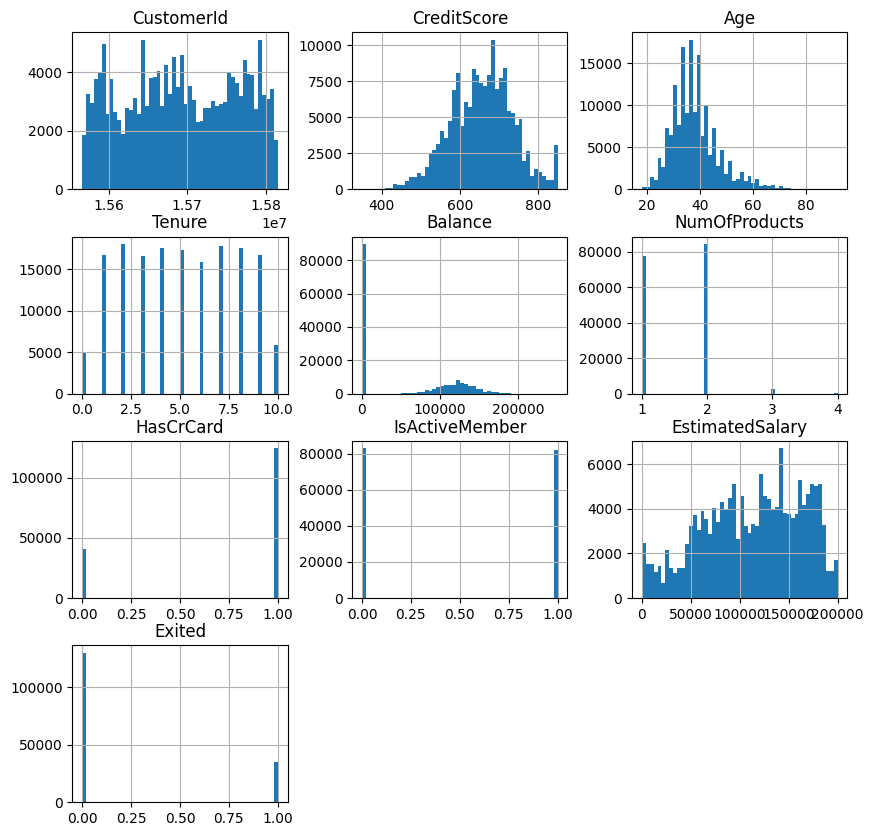

In [11]:
df_train.hist(figsize=(10,10), bins=50)

<Axes: xlabel='Gender', ylabel='count'>

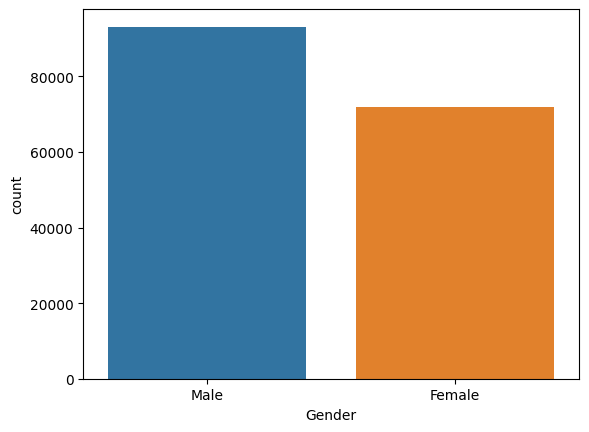

In [12]:
# let's check the categorical variables as well
sns.countplot(x='Gender', data=df_train)

<Axes: xlabel='Geography', ylabel='count'>

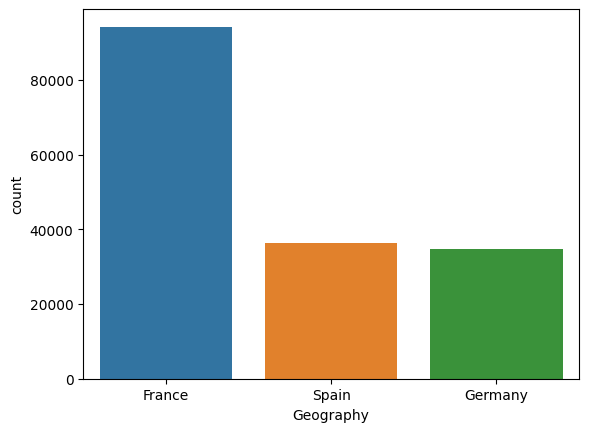

In [13]:
sns.countplot(x="Geography",data=df_train)

In [14]:
minority_class, majority_class=(df_train["Exited"].value_counts().iloc[1],df_train["Exited"].value_counts().iloc[0])
minority_class,majority_class

(34921, 130113)

In [15]:
imbalance=minority_class/(minority_class+majority_class)
imbalance

0.21159882206090866

#### We can clearly see that the minority class represents ~ 21% of the dataset.
#### This is not a severe imbalance but still it is an imbalance we should keep in mind.
#### Additionally, we also note that "Balance" has a lot of zeros and then a normal looking distribution. We also see that the "NumOfProds" has very less 3 and 4

<Axes: >

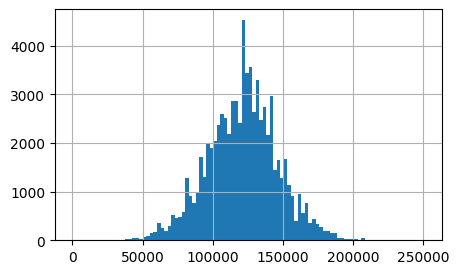

In [16]:
df_train["Balance"][df_train["Balance"]!=0].hist(figsize=(5,3),bins=100)

#### Keeping the above in mind we will engineer a binary variable which will indicate whether "Balances" ==0

### Let us recap some of our understanding of the data before we go on to engineer some features
1. No null values
2. No outliers
3. Create binary for "Balance"
4. We will create a new feature by creating "NumOfProducts"=2,3, or 4

### Feature Engineering

In [17]:
df_train["x_Balance"]=0
df_train.loc[df_train["Balance"]!=0,"x_Balance"]=1
df_train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,x_Balance
id,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0


In [18]:
df_train["NumOfProducts"].value_counts()

NumOfProducts
2    84291
1    77374
3     2894
4      475
Name: count, dtype: int64

In [19]:
# we will merge the 3s and 4s as they are very sparse
df_train["NumOfProdBins"] = np.where(df_train["NumOfProducts"] == 1, "1", "2-4")
df_train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,x_Balance,NumOfProdBins
id,,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,2-4
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,2-4
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,2-4
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1,1
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,2-4


#### Next we will do the one hot encoding of all the categorical variables

In [20]:
cols_to_encode=["Geography","Gender","NumOfProdBins"]

In [21]:
df_train=pd.get_dummies(df_train, columns=cols_to_encode,dtype=int)
df_train.head()

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,x_Balance,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProdBins_1,NumOfProdBins_2-4
id,,,,,,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,1,0,0,0,1,0,1
1,15749177,Okwudiliolisa,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1,0,0,0,1,0,1
2,15694510,Hsueh,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,1,0,0,0,1,0,1
3,15741417,Kao,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1,1,0,0,0,1,1,0
4,15766172,Chiemenam,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0,0,1,0,1,0,1


### We will use both undersampling and SMOTE methods to reduce the data imbalance

In [22]:
# importing libraries to perform statistical analysis
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score

In [23]:
X_train = df_train.drop('Exited', axis=1) 
y_train = df_train['Exited']

In [24]:
X_train.head()

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x_Balance,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProdBins_1,NumOfProdBins_2-4
id,,,,,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,1,0,0,0,1,0,1
1,15749177,Okwudiliolisa,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,1,0,0,0,1,0,1
2,15694510,Hsueh,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,1,0,0,0,1,0,1
3,15741417,Kao,581,34.0,2,148882.54,1,1.0,1.0,84560.88,1,1,0,0,0,1,1,0
4,15766172,Chiemenam,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0,1,0,1,0,1


### Models under consideration: Our final output is supposed to be probabilities. Logistic regression is an obvious first choice to generate classification probabilities. Apart from that we will use tree based approaches which are intrisically not sensitive to class imbalance. Finally we will use a neural network

In [25]:
X=X_train.drop(columns=['CustomerId','Surname'])
y=y_train

In [26]:
X

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x_Balance,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProdBins_1,NumOfProdBins_2-4
id,,,,,,,,,,,,,,,,
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,1,0,0,0,1,0,1
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,1,0,0,0,1,0,1
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,1,0,0,0,1,0,1
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,1,1,0,0,0,1,1,0
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,0,0,1,1,0,1,0
165030,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,1,0,0,0,1,1,0
165031,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,1,0,0,0,1,1,0


In [27]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=55, stratify=y)

### Lets start modelling

In [28]:
# logistic regression
model_logistic=LogisticRegression()
model_logistic.fit(train_X,train_y)

LogisticRegression()

In [29]:
# Make predictions
y_probs_logistic = model_logistic.predict_proba(val_X)[:, 1]  # Probabilities of the positive class

In [30]:
def AUC(y_test,y_probs):
    auc = roc_auc_score(y_test, y_probs)
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, color='orange', label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    return auc

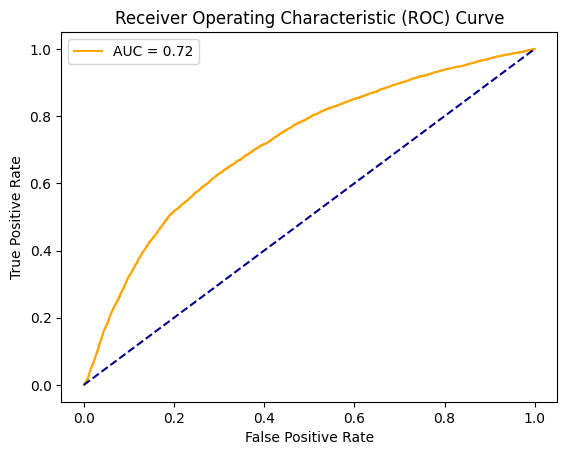

0.7159669398103599

In [31]:
AUC(val_y,y_probs_logistic)

In [32]:
# undersample
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=55)
X_train_under, y_train_under = undersample.fit_resample(train_X, train_y)

# SMOTE
smote = SMOTE(random_state=55)
X_train_smote, y_train_smote = smote.fit_resample(train_X, train_y)

In [33]:
model_under_sample=model_logistic.fit(X_train_under,y_train_under)
model_smote=model_logistic.fit(X_train_smote,y_train_smote)

In [34]:
# Make predictions
y_probs_under = model_under_sample.predict_proba(val_X)[:, 1]  # Probabilities of the positive class

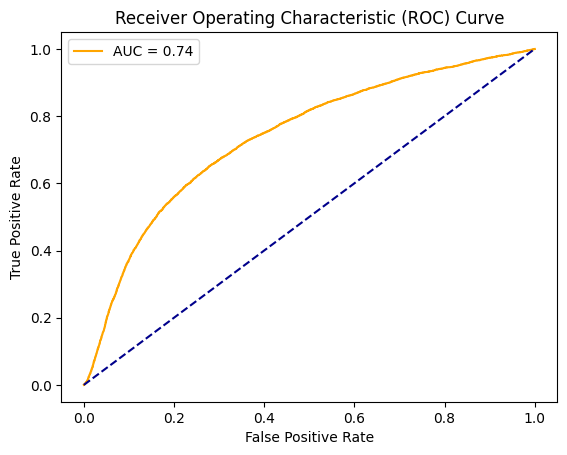

0.738291978824442

In [35]:
AUC(val_y,y_probs_under)

In [36]:
# Make predictions
y_probs_smote = model_smote.predict_proba(val_X)[:, 1]  # Probabilities of the positive class

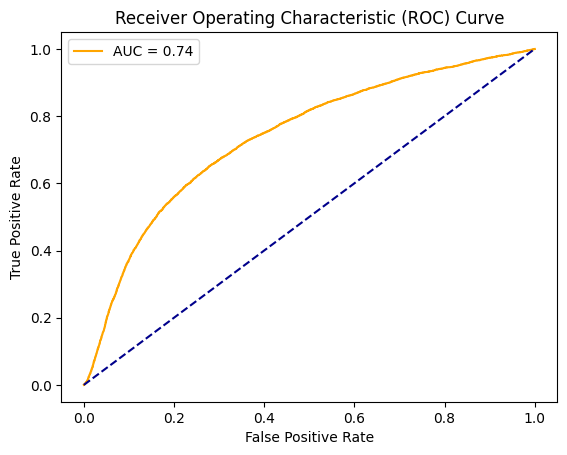

0.738291978824442

In [37]:
AUC(val_y,y_probs_smote)

In [38]:
# before applying a neurall network, let us standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(train_X)
X_test_scaled = scaler.transform(val_X)

In [39]:
X_train_scaled

array([[-0.29253656,  0.09749776, -0.00701994, ...,  0.87834215,
        -0.93845602,  0.93845602],
       [ 2.22837099, -1.48194998,  1.06156772, ...,  0.87834215,
        -0.93845602,  0.93845602],
       [-0.65444903, -0.12813763,  0.70537183, ..., -1.1385085 ,
        -0.93845602,  0.93845602],
       ...,
       [ 0.06937591, -0.12813763,  1.4177636 , ...,  0.87834215,
         1.06558003, -1.06558003],
       [-0.32997578,  1.4513101 , -1.0756076 , ..., -1.1385085 ,
         1.06558003, -1.06558003],
       [-0.50469215, -0.57940841,  0.70537183, ..., -1.1385085 ,
         1.06558003, -1.06558003]])

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(train_y, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(val_y.values, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [41]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(train_X.shape[1], 12)
        self.dropout1 = nn.Dropout(0.5)  # Dropout layer
        self.fc2 = nn.Linear(12, 6)
#         self.dropout2 = nn.Dropout(0.5)  # Another dropout layer
        self.fc3 = nn.Linear(6, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout
        x = F.relu(self.fc2(x))
#         x = self.dropout2(x)  # Apply dropout
        x = torch.sigmoid(self.fc3(x))
        return x

net = Net()

In [42]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

In [43]:
y_probs = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = net(inputs)
        y_probs.extend(outputs.squeeze().numpy())

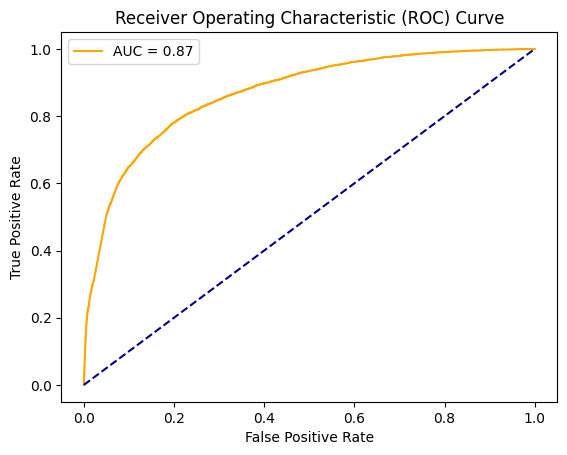

0.8682363229302971

In [44]:
AUC(val_y,y_probs)